In [3]:
import datasets as hfds

import minai.datasets as minds
import minai.data as mind
import minai.sampler as mins
import minai.plot as minplt
import minai.mintils as mintils

mind.COIOPTS.DEFAULT_DEVICE = "cuda"

minplt.default_cmap("gray")
minplt.default_title_color("white")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
dsd = minds.hf_load(minds.HF_DATASETS.FASHION_MNIST)

Found cached dataset fashion_mnist (/home/nblzv/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
tdsd = dsd.with_transform(
    mind.HFTransform.ff_img_decode_to_tensor(mind.first_value(dsd).features, n_channels=1, half=True),
).cast_column("image", hfds.Image(decode=False))

/home/nblzv/git/fastai_course22p2/minai/minai/data.py:467: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1687158866840/work/torch/csrc/utils/tensor_new.cpp:1505.)
  raw = torch.frombuffer(xs[i]["bytes"], dtype=torch.uint8)


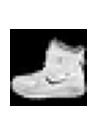

In [7]:
dl = mind.DataLoader.hf(tdsd["train"])
batch = mind.first(dl)
minplt.show_img(batch[0][0], minplt.POPTS(title=batch[1][0], figsize=(1, 1)))

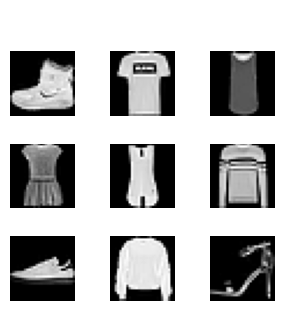

In [8]:
opts = minplt.POPTS(rows=3, 
                       cols=3, 
                       figsize=(3, 3),
                       title="Batch",
                       titles=[[x.item(), -x.item()] for x in batch[1]])
minplt.show_batch(batch[0], opts)

In [9]:
dld = mind.DataLoaderDict.hf(tdsd, mind.COPTS(num_threads=1), mins.SIOPTS(256))
dt = dld["train"]
dv = dld["test"]

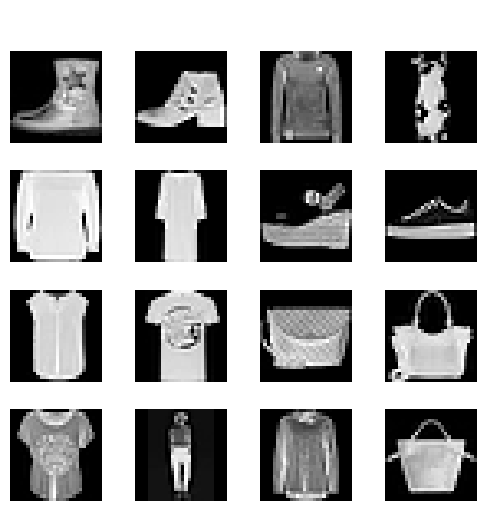

In [10]:
xb, yb = mind.first(dt)

opts = minplt.POPTS(rows=4, 
                       cols=4, 
                       figsize=(5, 5),
                       title="Batch",
                       titles=dt.ds.features["label"].int2str(yb))
minplt.show_batch(xb, opts)

In [11]:
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F

lr = 0.4

In [12]:
def conv(inp, out, ks=3, stride=2, act=True):
    res = nn.Conv2d(inp, out, ks, stride, ks//2)
    if act: res = nn.Sequential(res, nn.LeakyReLU())
    return res

def accuracy(preds, yb): 
    return (preds.argmax(1) == yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    mintils.push_timing_scope()
    debug_train = 0
    debug_batch = 0
    debug_eval = 0

    for epoch in range(epochs):
        if debug_train: mintils.push_timing_scope()
        model.train()

        if debug_batch: mintils.push_timing_scope()
        for xb, yb in train_dl:
            if debug_batch: mintils.pop_print_timing_scope("batch")

            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            if debug_batch: mintils.push_timing_scope()
        if debug_batch: mintils.pop_timing_scope()

        if debug_train: mintils.pop_print_timing_scope("train")

        if debug_eval: mintils.push_timing_scope()
        model.eval()
        with torch.no_grad():
            tot_loss = tot_acc = count = 0
            for xb, yb in valid_dl:
                preds = model(xb)

                n = len(xb)
                count += n
                tot_loss += loss_func(preds, yb).item()*n
                tot_acc += accuracy(preds, yb).item()*n
            print(f"{epoch}, {tot_loss/count:.4f}, {tot_acc/count:.4f}")
        if debug_eval: mintils.pop_print_timing_scope("eval")

    mintils.pop_print_timing_scope(f"fit for {epochs} took")
    return tot_loss/count, tot_acc/count

In [13]:
cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten()
).half().to(mind.COIOPTS.DEFAULT_DEVICE)

In [14]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0, 1.1253, 0.6043
1, 0.5769, 0.7847
2, 0.5208, 0.8032
3, 0.4660, 0.8286
4, 0.4489, 0.8328
fit for 5 took 28.489s


In [47]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act:
        layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

In [48]:
def ae_eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss = count = 0
        for xb, _ in valid_dl:
            preds = model(xb)

            n = len(xb)
            count += n
            tot_loss += loss_func(preds, xb).item()*n
        print(f"{epoch}, {tot_loss/count:.4f}")

In [49]:
def ae_fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    debug_batch = 0

    for epoch in range(epochs):
        model.train()

        if debug_batch: mintils.push_timing_scope()
        for xb, _ in train_dl:
            if debug_batch: mintils.pop_print_timing_scope("batch")

            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            if debug_batch: mintils.push_timing_scope()
        if debug_batch: mintils.pop_timing_scope()

        ae_eval(model, loss_func, valid_dl, epoch)

In [55]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),
    conv(1, 2),
    conv(2, 4),
    conv(4, 8),
    deconv(8, 4),
    deconv(4, 2),
    deconv(2, 1, act=False),
    nn.ZeroPad2d(-2),
    nn.Sigmoid()
).half().to(mind.COIOPTS.DEFAULT_DEVICE)

In [56]:
ae_eval(ae, F.mse_loss, dv)

0, 0.2005


In [57]:
opt = optim.SGD(ae.parameters(), lr=0.1)
ae_fit(10, ae, F.mse_loss, opt, dt, dv)

0, 0.1074
1, 0.0387
2, 0.0353
3, 0.0327
4, 0.0302
5, 0.0297
6, 0.0283
7, 0.0277
8, 0.0270
9, 0.0276


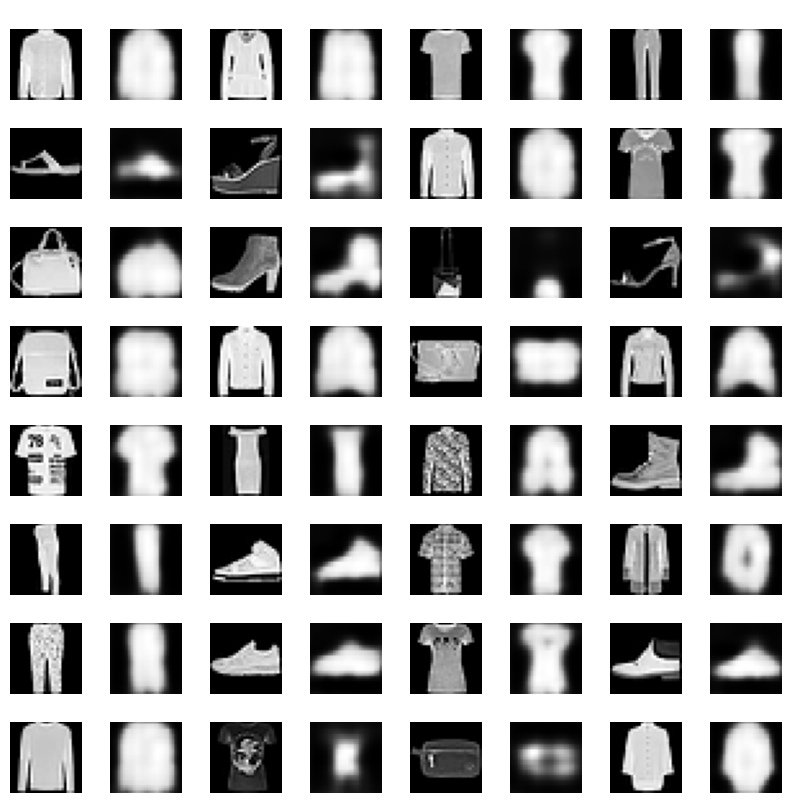

In [58]:
preds = ae(xb)
stacked = torch.stack([xb, preds], dim=1).view(xb.shape[0]*2, *xb.shape[1:])
minplt.show_batch(stacked, minplt.POPTS(titles=[*["Real", "Pred"]*64], rows=8, cols=8, figsize=(8,8)))

#minplt.show_batch(preds, minplt.POPTS(rows=4, cols=4, figsize=(4,4)))
#minplt.show_batch(xb, minplt.POPTS(rows=4, cols=4, figsize=(4,4)))